In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
from deluca.agents import Hinf
from deluca.envs import LDS
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [176]:
cummean = lambda x: np.cumsum(x)/(np.ones(T) + np.arange(T))
n, m = 2, 1
T = 100

In [183]:
def loop(context, i):
    env, controller = context
    action = controller(env.obs)
    env.step(action)
    env.state += 0.5 * jnp.sin(i) # add sine noise
    error = jnp.linalg.norm(env.state)+jnp.linalg.norm(action)
    return (env, controller), error

def loop_scan(context, K):
    env, i = context
    action = -K @ env.obs
    env.step(action)
    env.state += 0.5 * jnp.sin(i) # add sine noise
    error = jnp.linalg.norm(env.state)+jnp.linalg.norm(action)
    return (env, i+1), error

def get_errs(T, env, controller):
    avg_err = 0
    for i in range(T):
        (env, controller), error = loop((env, controller), i)
        avg_err += error/T
    return avg_err

def get_errs_scan(T, env, controller):
    xs = jnp.array(jnp.arange(T))
    K = jnp.array(controller.K)
    _, errs = jax.lax.scan(loop_scan, (env, 0), K)
    return errs

hinf incurs  0.7369849513183304  loss under sine noise


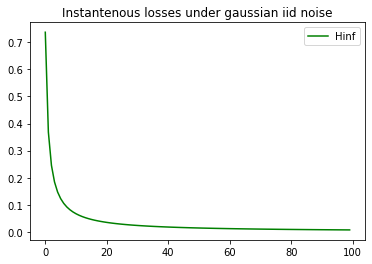

In [184]:
A,B,C = jnp.array([[0.5,0.5], [0.,1.]]), jnp.array([[1.],[0.]]), jnp.array([[1.,0], [0,1.]])
hinf = Hinf(A, B, T)
hinf.train(A, B, T)
env = LDS(state_size=2,
          action_size=1,
          A=A,
          B=B,
          C=C)
hinf_errs = get_errs(T, env, hinf)
print("hinf incurs ", np.mean(hinf_errs), " loss under sine noise")

plt.title("Instantenous losses under gaussian iid noise")
plt.plot(cummean(hinf_errs), "green", label = "Hinf")
plt.legend();

In [185]:
A,B,C = jnp.array([[0.5,0.5], [0.,1.]]), jnp.array([[1.],[0.]]), jnp.array([[1.,0], [0,1.]])
hinf = Hinf(A, B, T)
hinf.train(A, B, T)
env = LDS(state_size=2,
          action_size=1,
          A=A,
          B=B,
          C=C)
hinf_errs_scan = get_errs_scan(T, env, hinf)
print("hinf with scan incurs ", np.mean(hinf_errs_scan), " loss under sine noise")

hinf with scan incurs  0.7369849513183305  loss under sine noise
